In [2]:
%matplotlib inline

0
Patient-id: 10194022
left


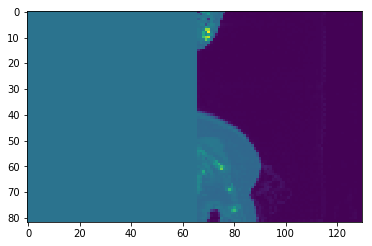

Well located
starting segmentation...
225


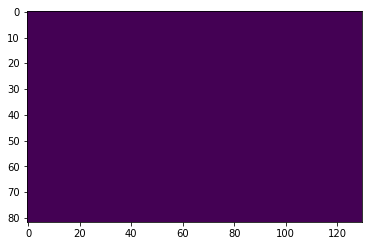

Elapsed time: 5.378 seconds.


In [3]:
#%%writefile segmentation_3D_firstversion

from segmentation_functions import resample, grow
from automaticSeeding import find_seed
from .finding_biggest_lung import arrange_slices, normalization, get_pixels_hu
from seed_evaluation import evaluate_seed
import scipy.ndimage.interpolation as inter
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as spio
import pydicom
import time


slices_path = "G:/CTimages/original/"
indices_path ="G:/Results/Lungs Masks indexes/ok/Separated Lungs"
separation_path = "G:/Results/Separator/"
segmentations_results_path = "G:/Plans/CT/Lungs/segmentation_results/first/"
indices_folder= os.listdir(indices_path)

results = []

for num,each_mask in enumerate(indices_folder[0:1]):):
    print(num)
    
    #Loading data--------------------------------------------------------------------------------------------------------
    opened = spio.loadmat(indices_path+'/'+each_mask, squeeze_me=True)["indexes"]
    patient_id = each_mask.split(" ", each_mask.count(each_mask))[0] 
    separador = spio.loadmat(separation_path+'/'+patient_id+'_separator', squeeze_me=True)["separator"]
    pre_region = each_mask.split("_", each_mask.count(each_mask))[1]
    region = pre_region.split("_", pre_region.count(pre_region))[0] 
    print("Patient-id: "+ str(patient_id))
    print(region)

    #Reading the data--------------------------------------------------------------------------------------------------------
    slices= arrange_slices(slices_path,patient_id)
    normalized_volume=normalization(slices)
    normalized_array = np.array(normalized_volume)
    
    #Separating left and right side------------------------------------------------------------------------------------------
    #possible improvement: define non-used side as the minimum of intensity of the volume
    volume = np.zeros(normalized_array.shape) 
    cols = normalized_array.shape[2]
    if region=='left':
        volume[:,:,separador:cols] = normalized_array[:,:,separador:cols]
    elif region =='right':
        volume[:,:,0:separador] = normalized_array[:,:,0:separador]
    volume_resampled, spacing = resample(volume, slices, [5,5,5])
    
          
    #Seed--------------------------------------------------------------------------------------------------------------------
    max_seeding = 39705+50
    min_seeding = 3257
    seed_1 = [0,0,0]
    seed_thresh = 0
    while seed_1 == [0,0,0]:
        seed_1 = find_seed(volume_resampled,seed_thresh,region) #tuple
        if seed_1 == [0,0,0]:
            seed_thresh= seed_thresh+15
    seeds = [seed_1] #list
          
    interval = volume_resampled.copy()
    interval[seed_1]=5000
    plt.imshow(interval[:,50,:])
    plt.show()
    
    evaluation = evaluate_seed(seeds[0], opened, slices, normalized_array, region, patient_id)
    results.append(evaluation)
    
    
    #Segmentation------------------------------------------------------------------------------------------------------------
    thresh = 225
    vizinhanca = 1
    first_seg = np.zeros(volume_resampled.shape, dtype=np.bool)
    size_seeds = len(seeds)
    counter = max_seeding+50
    while counter > max_seeding or counter< min_seeding:
        if size_seeds>1:
            for i in range(len(seeds)-1):
                start = time.time()
                seg, counter = grow(volume_resampled,seeds[i],thresh,vizinhanca,first_seg) 
                print('finish:'+str(i))
                if counter>max_seeding:
                    thresh = thresh-10
                if counter<min_seeding:
                    thresh = thresh+10
                else:
                    first_seg = seg
        else:
            print('starting segmentation...')
            #pre_seed = tuple(seeds)
            pre_seed = tuple(seeds[0])
            start = time.time()
            seg, counter = grow(volume_resampled,pre_seed,thresh,vizinhanca,first_seg)
            stop = time.time()
            print(thresh)
            if counter>max_seeding:
                thresh = thresh-10
            if counter<min_seeding:
                thresh = thresh+10
        plt.imshow(seg[:,50,:])
    plt.show()
    print("Elapsed time: %.3f seconds." % (stop - start))
    
    #Saving------------------------------------------------------------------------------------------------------------------
    name = segmentations_results_path+"3DVolumeSegmented_"+str(patient_id)+'_'+str(region)+"_"+str(thresh)
    np.save(name, seg)
    
    del slices
    del seg
    del normalized_array
#max_global= 39705
#min_global= 3257


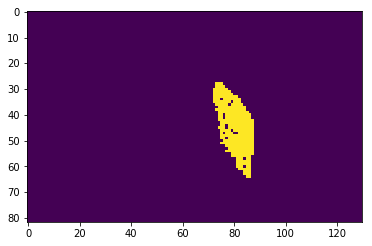

In [4]:
patient_id = "10194022" 
opened = spio.loadmat(indices_path+'/' +str(patient_id)+' - ct_left_lung_coordinates', squeeze_me=True)["indexes"]
slices= arrange_slices(slices_path,patient_id)
normalized_volume=normalization(slices)
normalized_array = np.array(normalized_volume)
volume_resampled, spacing = resample(normalized_array, slices, [5,5,5])
seed = find_seed(volume_resampled, 0,"left")
pre_seed = tuple(seed)
thresh = 225
seg = np.zeros(volume_resampled.shape, dtype=np.bool)
seg, counter = grow(volume_resampled,seed,thresh,1,seg)


# Checking if the slice thickness is always the same

In [19]:
from segmentation_functions import resample, grow
from automaticSeeding import find_seed
from .finding_biggest_lung import arrange_slices, normalization, get_pixels_hu
import scipy.ndimage.interpolation as inter
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as spio
import pydicom
import time


slices_path = "G:/CTimages/original/"
indices_path ="G:/Results/Lungs Masks indexes/ok/Separated Lungs"
separation_path = "G:/Results/Separator/"
segmentations_results_path = "G:/Plans/CT/Lungs/segmentation_results/first/"
indices_folder= os.listdir(indices_path)
# Results of seeding method 
results = []

for num,each_mask in enumerate(indices_folder):
    print(num)
    patient_id = each_mask.split(" ", each_mask.count(each_mask))[0] 
    
    folder_path = slices_path
    patient = patient_id
    #Reading the data--------------------------------------------------------------------------------------------------------
    path = folder_path + patient
    all_slices_names = []
    all_slices=[]
    all_slices = [pydicom.dcmread(path + '/' + file) for file in os.listdir(path)]
    #print("all_slices: " + str(len(all_slices)))
    slices = [s for s in all_slices if s.__contains__("ImagePositionPatient")==True]
    #print("slices: " + str(len(slices)))
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    print('intercept',slices[0].RescaleIntercept)
    print('slope',slices[0].RescaleSlope)
    print('thickness',slices[0].SliceThickness)
    print('pixel_spacing_1',slices[0].PixelSpacing[0])
    print('pixel_spacing_2',slices[0].PixelSpacing[1])
    print('___________________________________________')

0
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 1.269531
pixel_spacing_2 1.269531
___________________________________________
1
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 1.269531
pixel_spacing_2 1.269531
___________________________________________
2
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 9.76562e-1
pixel_spacing_2 9.76562e-1
___________________________________________
3
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 9.76562e-1
pixel_spacing_2 9.76562e-1
___________________________________________
4
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 1.269531
pixel_spacing_2 1.269531
___________________________________________
5
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 1.269531
pixel_spacing_2 1.269531
___________________________________________
6
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 1.269531
pixel_spacing_2 1.269531
___________________________________________
7
intercept -1024
slope 1
thickness 2.5
pixel_spacing_

intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 9.76562e-1
pixel_spacing_2 9.76562e-1
___________________________________________
61
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 9.76562e-1
pixel_spacing_2 9.76562e-1
___________________________________________
62
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 1.0625
pixel_spacing_2 1.0625
___________________________________________
63
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 1.0625
pixel_spacing_2 1.0625
___________________________________________
64
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 9.76562e-1
pixel_spacing_2 9.76562e-1
___________________________________________
65
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 9.76562e-1
pixel_spacing_2 9.76562e-1
___________________________________________
66
intercept -1024
slope 1
thickness 2.5
pixel_spacing_1 9.76562e-1
pixel_spacing_2 9.76562e-1
___________________________________________
67
intercept -1024
slope 1
thickness 2.5
pixel

AttributeError: 'FileDataset' object has no attribute 'RescaleIntercept'

(-0.5, 99.5, 107.5, -0.5)

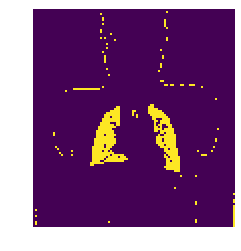

In [38]:
plt.imshow(mask_more[:,volume_resampled.shape[1]//2,:])#, cmap=plt.cm.gray)
plt.axis('off')